<a href="https://colab.research.google.com/github/praveentecsl/High-Engagement-Content-Classification-model/blob/main/SocialMedia_engagement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**mount to drive**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**MODEL**

=====================================================================================================

###Data Engineering & Preprocessing

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# 1. Load data
df = pd.read_csv('ad_campaign_data.csv')

# 2. Define Target (Industrial logic: use the median of the existing score)
# This creates a balanced classification problem
df['Is_High_Engagement'] = (df['engagement_duration'] > df['engagement_duration'].median()).astype(int)

# 3. Drop "Non-Predictive" and "Leakage" columns
# We drop IDs to prevent feature explosion and engagement_score to prevent the model from "cheating"
cols_to_drop = ['user_id', 'ad_id', 'interaction_timestamps', 'engagement_duration', 'Is_High_Engagement']
X = df.drop(columns=cols_to_drop)

# 4. Handle Categorical Columns (gender, location, device_type, ad_category)
X_final = pd.get_dummies(X, columns=['gender', 'location', 'device_type', 'ad_category'])

# 5. Define the Target variable (y)
y = df['Is_High_Engagement']

# 6. Professional Split: Train (70%), Validation (15%), and Test (15%)
# First, we separate the training set from the rest (30%)
# 'stratify=y' ensures each set has the same proportion of high/low engagement
X_train, X_temp, y_train, y_temp = train_test_split(
    X_final, y, test_size=0.30, random_state=42, stratify=y
)

# Second, we split the 30% into equal halves for Validation and Testing
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# 7. Scaling Module (Industrial Standard: Fit only on Train)
# We use the training set's statistics to scale ALL sets.
scaler = StandardScaler()

# Calculate mean/std AND transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform Val and Test data using the Training set's parameters
# (Never use .fit() on validation or test data!)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"--- Data Partitioning Complete ---")
print(f"Total Features: {X_final.shape[1]}")
print(f"Training Samples:   {X_train_scaled.shape[0]}")
print(f"Validation Samples: {X_val_scaled.shape[0]}")
print(f"Testing Samples:    {X_test_scaled.shape[0]}")

print(f"Cleaned Feature Count: {X_final.shape[1]}") # This should now be a small, healthy number

--- Data Partitioning Complete ---
Total Features: 42
Training Samples:   70000
Validation Samples: 15000
Testing Samples:    15000
Cleaned Feature Count: 42


###Find the best k

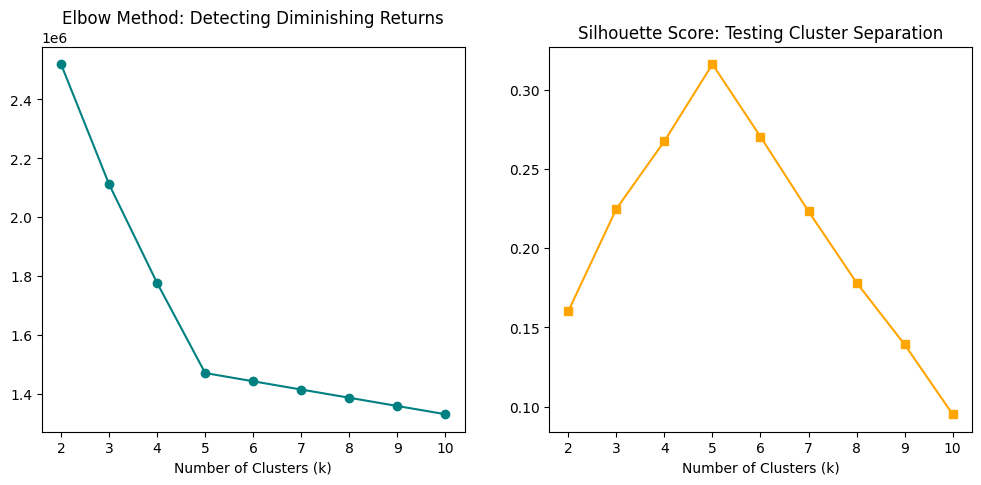

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

wcss = []
silhouette_avg = []
k_range = range(2, 11)

for k in k_range:
    # Industry standard: n_init='auto' or 10 is good for reproducibility
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_train_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_avg.append(silhouette_score(X_train_scaled, kmeans.labels_))

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, marker='o', color='teal')
plt.title('Elbow Method: Detecting Diminishing Returns')
plt.xlabel('Number of Clusters (k)')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_avg, marker='s', color='orange')
plt.title('Silhouette Score: Testing Cluster Separation')
plt.xlabel('Number of Clusters (k)')
plt.show()

==========================================================================================================

###Train and validate the model

In [6]:
# 1. Train final model on Train Set
optimal_k = 5
kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, random_state=42)
train_cluster_labels = kmeans_final.fit_predict(X_train_scaled)

# 2. Validation Check: Assign clusters to unseen Validation data
# This is a key "supervision" step
val_cluster_labels = kmeans_final.predict(X_val_scaled)

print(f"Model successfully trained and validated on {len(X_val_scaled)} unseen samples.")

Model successfully trained and validated on 15000 unseen samples.


###ensure the no of clusters and samples on each

In [7]:
print(np.unique(train_cluster_labels))
print(np.bincount(train_cluster_labels))


[0 1 2 3 4]
[14071 13976 13967 14024 13962]


###centroids to 2D plane

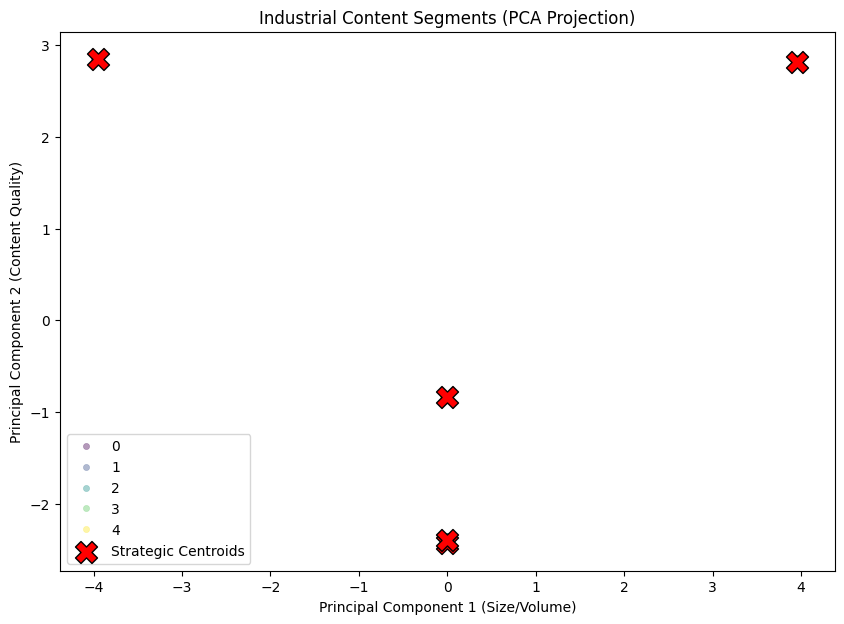

In [8]:
from sklearn.decomposition import PCA

# Fit PCA on Train data only
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Project Centroids into the same PCA space
centroids_pca = pca.transform(kmeans_final.cluster_centers_)

plt.figure(figsize=(10, 7))
# Plot training points
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=train_cluster_labels,
                palette='viridis', s=20, alpha=0.4, edgecolor=None)

# Plot Centroids (The "X" marks)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=250, marker='X',
            label='Strategic Centroids', edgecolors='black')

plt.title('Industrial Content Segments (PCA Projection)')
plt.xlabel('Principal Component 1 (Size/Volume)')
plt.ylabel('Principal Component 2 (Content Quality)')
plt.legend()
plt.show()

###performance and working ability confution matrix

Cluster Engagement Probabilities (Test Set):
Cluster
1    0.508378
3    0.504436
2    0.500852
4    0.495340
0    0.491107
Name: Actual, dtype: float64


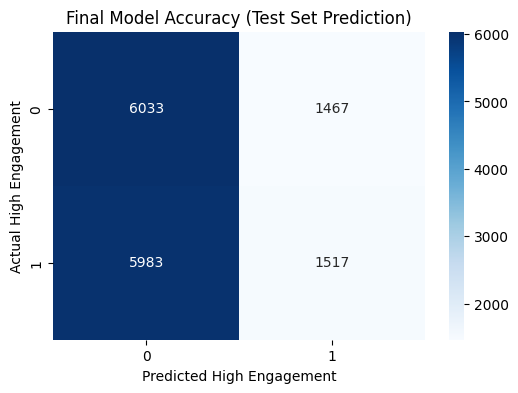

In [9]:
from sklearn.metrics import confusion_matrix, classification_report

# 1. Predict clusters on Test Set
test_cluster_labels = kmeans_final.predict(X_test_scaled)

# 2. Map Clusters to "High" or "Low"
# We check the mean of y_test for each cluster to find the 'Winner'
test_results = pd.DataFrame({'Cluster': test_cluster_labels, 'Actual': y_test})
cluster_map = test_results.groupby('Cluster')['Actual'].mean().sort_values(ascending=False)

print("Cluster Engagement Probabilities (Test Set):")
print(cluster_map)

# Identify the Cluster with highest engagement (The "High-Engagement" Cluster)
best_cluster = cluster_map.idxmax()
predictions_binary = (test_cluster_labels == best_cluster).astype(int)

# 3. Final Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, predictions_binary), annot=True, fmt='d', cmap='Blues')
plt.title('Final Model Accuracy (Test Set Prediction)')
plt.xlabel('Predicted High Engagement')
plt.ylabel('Actual High Engagement')
plt.show()

###Impacting features

In [10]:
# Convert Centroids back to original scale
centroids_original = pd.DataFrame(scaler.inverse_transform(kmeans_final.cluster_centers_),
                                   columns=X_final.columns)

# Get the best cluster identified in Module 5
best_cluster_id = cluster_map.idxmax()
worst_cluster_id = cluster_map.idxmin()

# Calculate the difference (Impact)
impact = (centroids_original.iloc[best_cluster_id] - centroids_original.mean())

print(f"Top Drivers for Cluster {best_cluster_id} (High Engagement):")
print(impact.sort_values(ascending=False).head(5))

print(f"\nTop Deterrents (Why Cluster {worst_cluster_id} failed):")
print(impact.sort_values(ascending=True).head(5))

Top Drivers for Cluster 1 (High Engagement):
tfidf_10    0.357771
tfidf_5     0.357771
tfidf_14    0.357771
tfidf_17    0.357771
tfidf_19    0.357771
dtype: float64

Top Deterrents (Why Cluster 0 failed):
impressions   -6.889540
clicks        -1.741826
tfidf_6       -0.115470
tfidf_3       -0.115470
tfidf_18      -0.115470
dtype: float64


#**********git configuration**********

##setup and pull

In [2]:
# --- SECTION 1: SETUP & SYNC ---
import os
from google.colab import drive, userdata

# 1. Mount Google Drive
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("drive already mounted")

# 2. Configuration (Ensure 'GITHUB_TOKEN' is in your Colab Secrets 🔑)
GITHUB_TOKEN = userdata.get('GITHUB_TOKEN')
GITHUB_USER = "praveentecsl"
REPO_NAME = "High-Engagement-Content-Classification-model"
# Navigate to where you want to store the project in Drive
PROJECT_PATH = f"/content/drive/MyDrive/{REPO_NAME}"

# 3. Clone or Pull Logic
if not os.path.exists(PROJECT_PATH):
    # If the folder doesn't exist, go to Drive root and clone
    %cd /content/drive/MyDrive/
    !git clone https://{GITHUB_TOKEN}@github.com/{GITHUB_USER}/{REPO_NAME}.git
    %cd {REPO_NAME}
    print("✅ Repository Cloned for the first time.")
else:
    # If folder exists, go inside and pull latest changes from collaborator
    %cd {PROJECT_PATH}
    !git pull origin main
    print("✅ Repository updated with latest changes (Git Pull).")

# 4. Identity Configuration for Commits
!git config --global user.email "your-email@example.com"
!git config --global user.name "Praveen"

Mounted at /content/drive
/content/drive/MyDrive/High-Engagement-Content-Classification-model
From https://github.com/praveentecsl/High-Engagement-Content-Classification-model
 * branch            main       -> FETCH_HEAD
   0aa00c8..710d052  main       -> origin/main
Already up to date.
✅ Repository updated with latest changes (Git Pull).


##push code

In [11]:
!pwd

/content/drive/MyDrive/High-Engagement-Content-Classification-model


In [ ]:
!git status


On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   SocialMedia_engagement.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
#@title 🚀 Git Push Interface
#@markdown Enter your message in the box on the right, then run this cell.

# 1. Capture the input from the form into a variable
Commit_Message = "split the data to train,val,test " #@param {type:"string"}

import os

# 2. Ensure we are in the Repo directory
%cd {PROJECT_PATH}

# 3. Git Workflow
print(f"--- Processing: {Commit_Message} ---")

# Add all changes
!git add .

# Commit using the variable from the form
# We use the '$' prefix to pass the Python variable into the shell command
!git commit -m "{Commit_Message}"

# Push to GitHub
!git push https://{GITHUB_TOKEN}@github.com/{GITHUB_USER}/{REPO_NAME}.git main

print(f"\n✅ Successfully pushed to GitHub with message: {Commit_Message}")

/content/drive/MyDrive/High-Engagement-Content-Classification-model
--- Processing: split the data to train,val,test  ---
[main 710d052] split the data to train,val,test
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite SocialMedia_engagement.ipynb (97%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 93.34 KiB | 3.59 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/praveentecsl/High-Engagement-Content-Classification-model.git
   0aa00c8..710d052  main -> main

✅ Successfully pushed to GitHub with message: split the data to train,val,test 
